### **Notebook Objectives**

1. **Visualize Reconstruction Quality:** Load and display saved Original, Baseline, and EQODEC frames side-by-side to enable qualitative inspection of compression artifacts and reconstruction differences.

2. **Aggregate Training Logs:** Load per-epoch JSON results from all model replicates and combine them into unified dataframes for downstream statistical analysis.

3. **Analyze Learning Dynamics:** Plot training and validation curves—such as loss, PSNR, and EES—showing mean trends across replicates for both models.

4. **Compare Final Model Performance:** Load aggregated statistics for Baseline and EQODEC and generate bar-chart comparisons with mean ± standard deviation for key metrics (EES, PSNR, overhead time, compressed size, CO₂ overhead).

5. **Export Analysis Outputs:** Save all visualizations (frame comparisons, epoch curves, and aggregated plots).

### **Results Analysis**

In [1]:
# Standard Library Imports
import os
import json
from typing import List, Optional, Dict

# Third-Party Library Imports
import numpy as np
import pandas as pd
from PIL import Image

# Plotting/Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Magic Command (kept for notebook environment execution)
%matplotlib inline

In [2]:
def load_and_display_saved_frame(
    output_dir: str,
    sequence_id: str,
    frame_index: int = 0,
    figsize: tuple = (15, 5)
):
    """
    Loads Original, EQODEC, and Baseline frames from disk for a specified 
    sequence and frame index, and displays them side-by-side.
    """
    
    frame_suffix = f"f{frame_index:02d}.png"
    
    orig_path = os.path.join(output_dir, f"{sequence_id}_original_{frame_suffix}")
    eqodec_path_out = os.path.join(output_dir, f"{sequence_id}_EQODEC_{frame_suffix}")
    baseline_path_out = os.path.join(output_dir, f"{sequence_id}_Baseline_{frame_suffix}")

    # Initialize handles to None
    img_orig = img_eqodec = img_baseline = None 
    fig = None

    try:
        # Check if all files exist
        if not all(os.path.exists(p) for p in [orig_path, eqodec_path_out, baseline_path_out]):
            print(f"[ERROR] One or more required image files not found for frame {frame_index}.")
            return
            
        # Load Images using PIL (PIL automatically closes file handles after loading)
        img_orig = Image.open(orig_path)
        img_eqodec = Image.open(eqodec_path_out)
        img_baseline = Image.open(baseline_path_out)
        
        # Matplotlib Plotting
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f"Comparison for Sequence: {sequence_id}, Frame {frame_index}", fontsize=14)
        
        axes[0].imshow(img_orig)
        axes[0].set_title("Original")
        axes[0].axis('off')

        axes[1].imshow(img_baseline)
        axes[1].set_title("Baseline")
        axes[1].axis('off')

        axes[2].imshow(img_eqodec)
        axes[2].set_title("EQODEC")
        axes[2].axis('off')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("../results/sequence_comparison.png", dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"\n[CRITICAL ERROR] Failed to load/display saved comparison frames: {e}")
    
    finally:
        # --- FIX 4: Ensure Matplotlib Resources are Released ---
        if fig is not None:
            plt.close(fig)
            
        # Optional: Explicitly break references to large PIL images (may not be necessary but is safe)
        del img_orig, img_eqodec, img_baseline

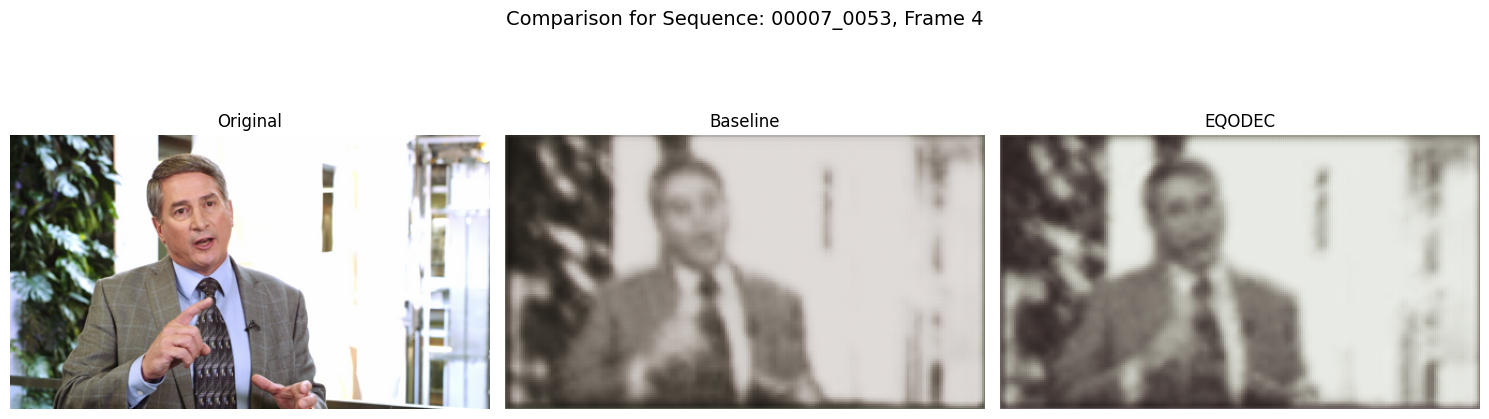

In [3]:
load_and_display_saved_frame(
    output_dir="../results/visual_comparison_frames",
    sequence_id="00007_0053",
    frame_index=4
)

In [4]:
def load_epoch_data(results_dir: str, model_name: str, n_runs: int) -> pd.DataFrame:
    """
    Loads and aggregates per-epoch results from all replicate JSON files
    for a given model name.
    """
    all_data = []
    model_prefix = model_name.lower()
    
    for i in range(1, n_runs + 1):
        json_path = os.path.join(results_dir, f"{model_prefix}_epoch_results_r{i}.json")
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
                # Add replicate ID and model name to each entry
                for entry in data:
                    entry['run_id'] = i
                    entry['model'] = model_name
                all_data.extend(data)
        except FileNotFoundError:
            print(f"Warning: File not found for {model_name} replicate {i}: {json_path}")
        except Exception as e:
            print(f"Error loading JSON for {model_name} replicate {i}: {e}")

    if not all_data:
        return pd.DataFrame()

    return pd.DataFrame(all_data)

# Constants derived from your code for convenience
RESULTS_DIR = "../results"
N_RUNS = 5

In [5]:
def plot_epoch_curves(
    results_dir: str, 
    metrics: List[str], 
    n_runs: int = N_RUNS, 
    baseline_name: str = "Baseline", 
    eqodec_name: str = "EQODEC"
):
    """
    Visualizes the training/validation curves for specified metrics (e.g., 'val_loss', 'test_psnr').
    Shows the mean and standard deviation across all replicates.
    """
    baseline_df = load_epoch_data(results_dir, baseline_name, n_runs)
    eqodec_df = load_epoch_data(results_dir, eqodec_name, n_runs)
    
    if baseline_df.empty and eqodec_df.empty:
        print("No epoch data found for either model. Check RESULTS_DIR and file names.")
        return
        
    # Combine dataframes
    combined_df = pd.concat([baseline_df, eqodec_df])
    
    for metric in metrics:
        if metric not in combined_df.columns:
            print(f"Warning: Metric '{metric}' not found in the loaded data. Skipping.")
            continue
            
        plt.figure(figsize=(10, 6))
        
        # Use seaborn's lineplot to plot the mean and standard deviation (via 'ci="sd"')
        sns.lineplot(
            data=combined_df, 
            x='epoch', 
            y=metric, 
            hue='model',
            linewidth=2,
            errorbar=None
        )
        
        # Format the plot
        plt.title(f'{metric.replace("_", " ").title()} per Epoch (Mean, N={n_runs})', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace("_", " ").title(), fontsize=12)
        plt.legend(title='Model')
        plt.xticks(combined_df['epoch'].unique()) # Ensure integer epochs are shown
        plt.tight_layout()
        plt.savefig(f"../results/{metric}_curve.png", dpi=300)
        plt.show()

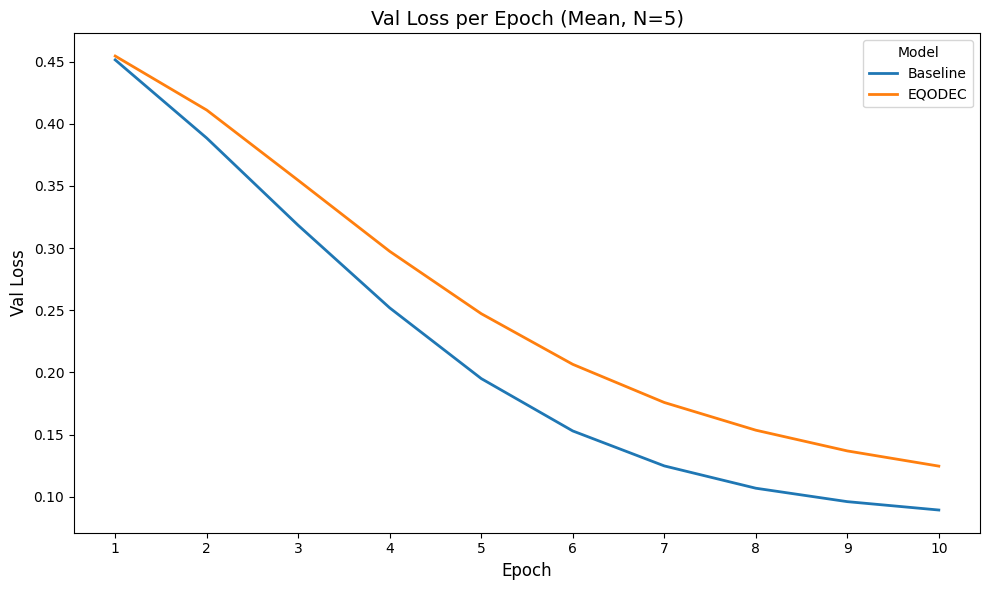

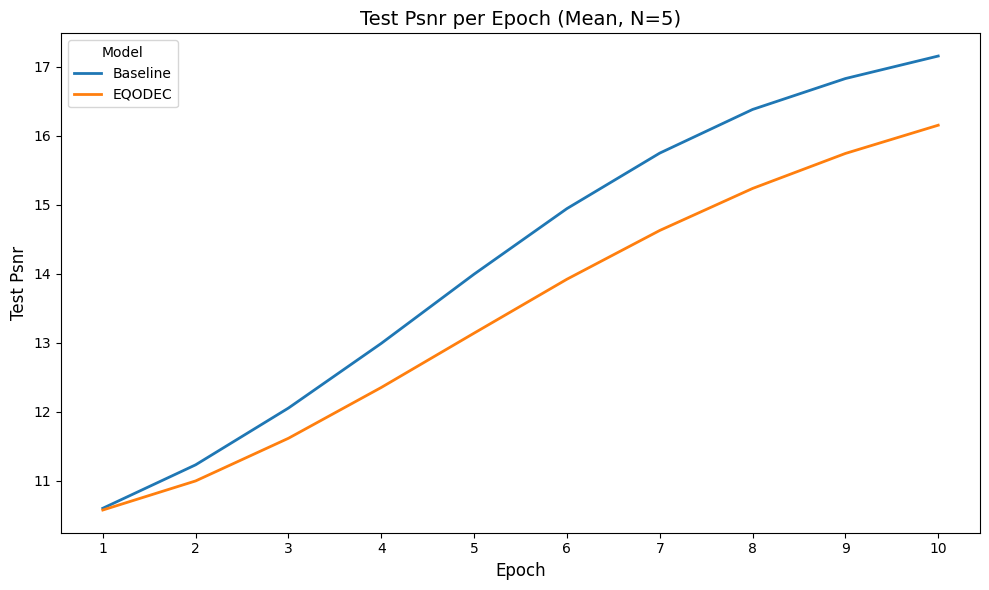

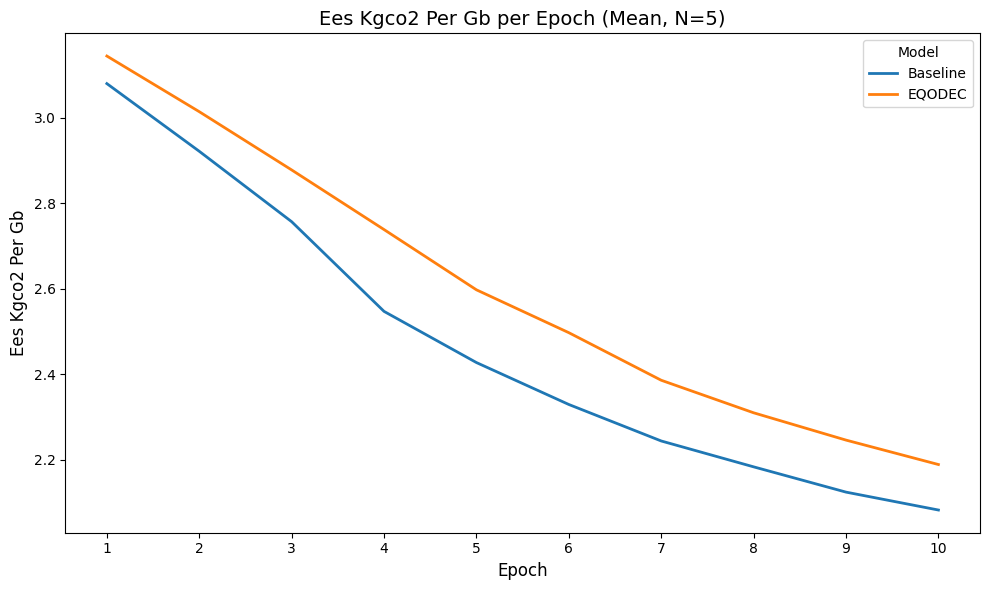

In [6]:
plot_epoch_curves(RESULTS_DIR, ['val_loss', 'test_psnr', 'ees_kgco2_per_gb'])

In [7]:
def plot_aggregated_comparison(
    results_dir: str, 
    metrics_to_plot: List[str], 
    baseline_agg_path: str, 
    eqodec_agg_path: str,
    base_channels: int = 20 # MODEL_BASE_CHANNELS from your code
):
    """
    Creates a bar chart comparing the mean and standard deviation of final 
    aggregated metrics between the EQODEC and Baseline models.
    """
    
    def load_aggregated(path: str) -> Optional[Dict]:
        """Utility to safely load aggregated stats."""
        try:
            with open(path, 'r') as f:
                return json.load(f)['stats']
        except FileNotFoundError:
            print(f"Error: Aggregated stats file not found at {path}")
            return None
        except Exception as e:
            print(f"Error loading aggregated stats from {path}: {e}")
            return None

    baseline_stats = load_aggregated(baseline_agg_path)
    eqodec_stats = load_aggregated(eqodec_agg_path)

    if not baseline_stats or not eqodec_stats:
        return

    # Prepare data for plotting
    plot_data = []
    
    # Map raw metric names to display names and units
    metric_map: Dict[str, Tuple[str, str]] = {
        "ees_kgco2_per_gb": ("Energy-Efficiency Score (EES)", "GB/kgCO2"),
        "avg_psnr": ("Test PSNR", "dB"),
        "t_model_overhead": ("Overhead Time", "s"),
        "model_size_gb": ("Compressed Size", "GB"),
        "model_kgco2_overhead": ("Total kgCO2 Overhead", "kgCO2"),
    }

    for raw_metric in metrics_to_plot:
        if raw_metric not in metric_map or raw_metric not in baseline_stats or raw_metric not in eqodec_stats:
            print(f"Warning: Metric '{raw_metric}' not available in aggregated stats. Skipping.")
            continue
            
        display_name, unit = metric_map[raw_metric]
        
        plot_data.append({
            'Metric': display_name,
            'Model': 'Baseline',
            'Mean': baseline_stats[raw_metric]['mean'],
            'StdDev': baseline_stats[raw_metric]['std'],
            'Unit': unit
        })
        plot_data.append({
            'Metric': display_name,
            'Model': 'EQODEC',
            'Mean': eqodec_stats[raw_metric]['mean'],
            'StdDev': eqodec_stats[raw_metric]['std'],
            'Unit': unit
        })

    df_plot = pd.DataFrame(plot_data)
    
    # Create subplots for each metric
    n_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(1, n_metrics, figsize=(4.5 * n_metrics, 6), sharey=False)
    
    if n_metrics == 1:
        axes = [axes] # Ensure axes is iterable even for a single metric
        
    for ax, (raw_metric, (display_name, unit)) in zip(axes, [(k, metric_map[k]) for k in metrics_to_plot if k in metric_map]):
        
        # Filter data for the current metric
        df_metric = df_plot[df_plot['Metric'] == display_name]
        
        # Plot bars with error bars
        sns.barplot(
            x='Model', 
            y='Mean', 
            data=df_metric, 
            hue='Model', 
            errorbar=None, # Barplot's default errorbar is 95% CI, we'll draw std manually
            palette={'Baseline': 'skyblue', 'EQODEC': 'salmon'},
            ax=ax
        )
        
        # Add standard deviation as error bars manually
        for model_name in ['Baseline', 'EQODEC']:
            row = df_metric[df_metric['Model'] == model_name].iloc[0]
            mean = row['Mean']
            std = row['StdDev']
            x_pos = 0 if model_name == 'Baseline' else 1
            ax.errorbar(x_pos, mean, yerr=std, fmt='none', capsize=5, color='black', alpha=0.7, zorder=3)

        # Annotate with mean ± std
        for i, row in df_metric.iterrows():
            ax.text(ax.patches[i % 2].get_x() + ax.patches[i % 2].get_width() / 2, 
                    row['Mean'] + row['StdDev'] * 1.1, # Place above the error bar
                    f"{row['Mean']:.3f} ± {row['StdDev']:.3f}", 
                    ha='center', va='bottom', fontsize=9, rotation=0)

        # Format the plot
        ax.set_title(display_name, fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel(f'Mean Value ({unit})', fontsize=11)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.legend([],[], frameon=False) # Hide legend on subplots

    fig.suptitle(f'EQODEC vs. Baseline: Final Performance Comparison (N={N_RUNS} Replicates)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig("../results/bar_chart.png", dpi=300)
    plt.show()

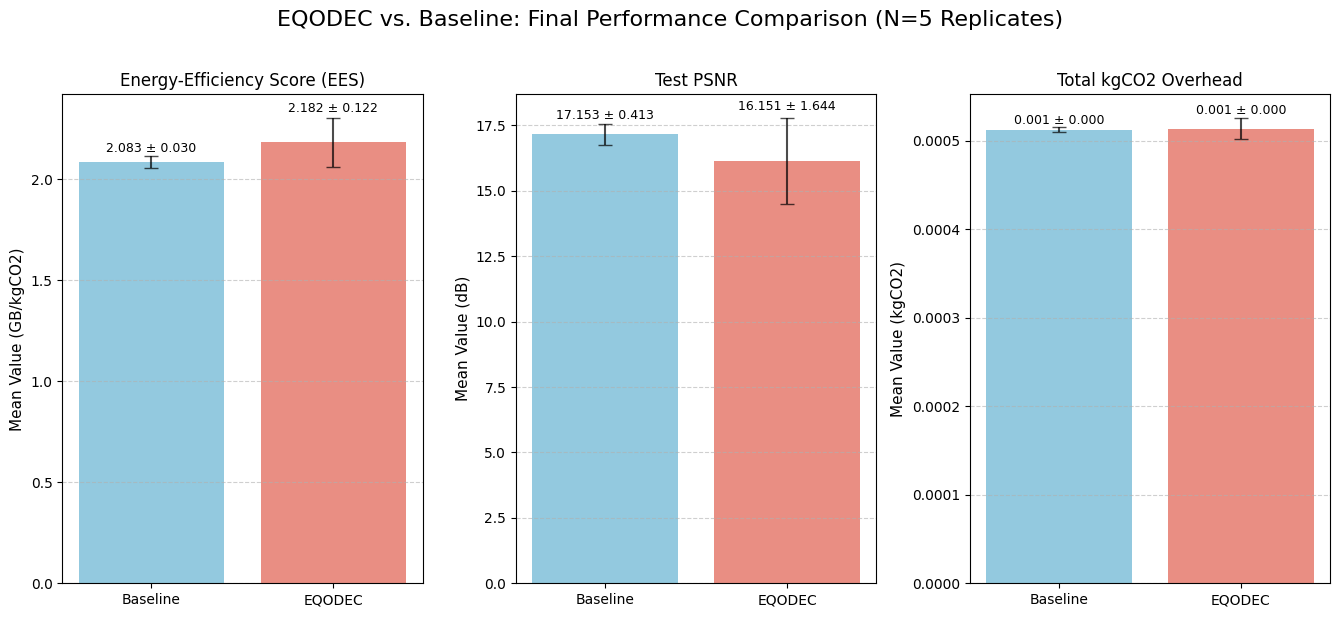

In [8]:
plot_aggregated_comparison(
    results_dir=RESULTS_DIR,
    metrics_to_plot=["ees_kgco2_per_gb", "avg_psnr", "model_kgco2_overhead"],
    baseline_agg_path=os.path.join(RESULTS_DIR, "baseline_aggregated_stats_b16.json"),
    eqodec_agg_path=os.path.join(RESULTS_DIR, "eqodec_aggregated_stats_b16.json")
)